# Complexity Project

Aim of complexity is to understand a subclass non-equilibrium systems

Models studies include:
1. Oslo Model

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from itertools import zip_longest
from scipy.optimize import curve_fit
from collections import Counter

### 1. Oslo Model
Grains are added to the left most pile, when the system has entered a staircase recurrent configuration, the grain the take L steps, before leaving the system. 

A recurrent configuration means that the system has reached a steady state, as it only occurs after all transient configurations have occured. Will occur with a frequency greater than one.

Previously, the Oslo model algorithm such that 
1. slopes would be driven, 
2. slopes would be relaxed changing z configuration. 
3. Check if any slope is larger than their threshold
    * If yes, repeat iteration across all slopes to relax
    * If no, generate new threshold and return to step 1)
    
Although simple, this implementation was extremely inefficient and would begin to face difficulty for system sizes of L > 50. Thus a more calculated approach was taken for the Oslo model, the algorithm goes as follows:

1. Drive slope
2. Relax slope i
3. Append to a list adjacent slopes of i (i.e. i+1, i-1), if z = z_+th + 1 (next_slopes)
    * If i = 1, or i = L, reduce only one neighbouring slope: i= 2 and i = L-1 respectively
4. If next_slopes are not empty, i.e. there are sites to relax, relax sites and repeat 3) if there are unrelaxed slopes. 
5. if next_slopes is empty, generate new random threshold and return to step 1) and drive system

- If in an edge case, where at site i has z_th of 1, and both site i-1 and site i+1 reduce, this would not reduce the slope sufficiently to be below the threshold. Thus append site i to next_slopes to relax in the following iteration

You wouldnt'expect the slope thresholds to be evenly split, because you are only driven from site i=1. Thus there are slopes closer to i =1 that are more regularly updated, in comparison to sites later down the slope. The fact that the later slopes remain in a certain threshold will skew the distribution

[1, 1]


[[2, 3, 4], array([0.2020202 , 0.48484848, 0.31313131])]

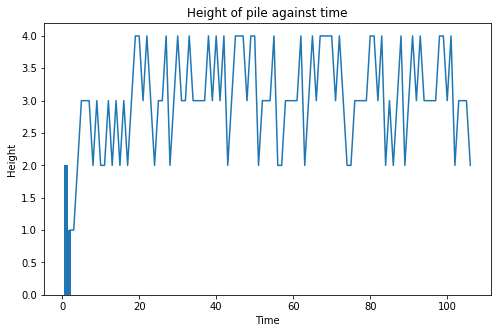

In [145]:
class Oslo:
    """
    Parameters
    L: Number of sites 
    plot: Plots heights if true
    p: probability
    N_recurrents: Number of recurrent runs after reaching steady state
    """
    
    def __init__(self,L, p =[1/2,1/2]):
        self.p = p
        self.L = L

    def run(self, plot=False, N_recurrents=None,title=None, check_slopes = False,N_runs = None):

        z = [0] * self.L

        # Allows for change in probabilities
        n = len(self.p)  # Number of thresholds, from probability
        z_ths = np.arange(1, n + 1, 1)  # Generates possible thresholds [1,2,...]

        # Initialisation
        z_th = [random.choice(z_ths) for x in range(self.L)]

        # Variables for testing
        end_value = 0
        self.avalanches = []
        z_avg_steady = []
        crossover = False  # To
        N_full_avalanche = 0  # Tracks full avalanches
        self.configurations = [[0]*self.L]  # Find number of unique STABLE configurations
        self.delta_heights = [0]
        self.cross_over_time = 0
        cross_over_time = 0
        
        if N_runs != None:
            N_count = N_runs
        elif N_recurrents != None:
            N_count = N_recurrents
        
        while end_value < N_count:

            # Drive
            z[0] += 1
            s = 0
            del_h = 1
            slopes_to_relax = [0]
            if crossover == False: cross_over_time += 1
            # Relaxation - Checks all slopes z relaxed, before driving again
            while len(slopes_to_relax) != 0:
                check_slopes = slopes_to_relax
                next_slopes = []
                for i in slopes_to_relax:
                    if z[i] > z_th[i]:
                        s += 1
#                         print(s,slopes_to_relax)
                        if i == 0:
                            z[i] = z[i] - 2
                            z[i+1] = z[i+1] + 1
                            if z[i+1] == z_th[i+1] + 1:
                                next_slopes.append(i+1)
                            del_h -= 1

                        elif i == len(z) - 1:  # index 0,...,L-1 ; len to L
                
                            z[len(z) - 1] = z[len(z) - 1] - 1
                            z[len(z) - 2] = z[len(z) - 2] + 1
                            crossover = True
                            if z[len(z) - 2] == z_th[len(z) - 2] + 1:
                                next_slopes.append(len(z) - 2)                            
                            if self.cross_over_time == 0: self.cross_over_time = cross_over_time

                        else:
                            z[i] = z[i] - 2
                            z[i + 1] = z[i + 1] + 1
                            z[i - 1] = z[i - 1] + 1

                            if z[i+1] == z_th[i+1] + 1:
                                next_slopes.append(i+1)
                            if z[i-1] == z_th[i-1] + 1:
                                next_slopes.append(i-1)
                            
                        z_th[i] = random.choice(z_ths)
                        if z[i] > z_th[i]:
                            next_slopes.append(i)
                    else:
                        pass

                if len(next_slopes) > 0:
                    # Finds unique next slopes.
                    slopes_to_relax = list(set(next_slopes))

                else:
                    slopes_to_relax = []
                    
                # out of for loop 
            self.avalanches.append(s)
            # out of while loop
            if N_runs != None:
                end_value +=1
            elif crossover == True:
                end_value += 1
                z_avg_steady.append(np.cumsum(z[::-1])[::-1][0])
#             else:
#                 raise ValueError("Not Counting!!")

                
            self.delta_heights.append(del_h)
                
            self.configurations.append(z[:].copy())
#             print(self.configurations)

            # Check
            if check_slopes == True:
                if any(x > max(z_ths) for x in z) == True:
                    print(z,z_th)
                    print(check_slopes)

                    raise ValueError("Not all sites relaxed")

        # Obtains cumulative sum of slopes, to represent heights
        final_heights = np.cumsum(z[::-1])[::-1]  # indexing to reverse list

        self.z = z.copy()

        if plot == True:
            print(self.z)
            self._plot_bar(z)
        
        self.times = np.arange(1,len(self.delta_heights)+1,1)
#         print(self.times)
        return final_heights, z, np.mean(z_avg_steady), self.configurations
    
    def get_heights(self,plot = True):
        heights = np.cumsum(self.delta_heights)
        time = self.times.copy()
        if plot == True:
            plt.xlabel("Time")
            plt.ylabel("Height")
            plt.title("Height of pile against time")
            plt.plot(time,heights,label = "L = {}".format(self.L))
        return time, heights

    def get_heights_attractor(self,plot = False):
        times, heights = self.get_heights(plot = False)
        times_crossed = times[self.cross_over_time:]
        # Shift so T starts at zero
        times_crossed -= self.cross_over_time
        heights_crossed = heights[self.cross_over_time +1:]
                
        heights_crossed = np.array([float(h) for h in heights_crossed])
        
        
        avg_height = 1/float(times_crossed[-1]) * sum(heights_crossed)
        avg_height_sq = 1/float(times_crossed[-1]) * sum(heights_crossed**2)
        
        self.std_dev = np.sqrt(avg_height_sq - avg_height **2)
        
        if plot == True:
            plt.plot(times_crossed,heights_crossed)
        return avg_height
    
    def get_std_heights(self):
        return self.std_dev
    
    def get_cross_over_times(self):
#         plt.axvline(self.cross_over_time)
        return self.cross_over_time

    def get_probability_heights(self):
        """
        Creats a dataframe of heights, and their counts from the configurations
        
        Returns a list of normalised probabilities form height = 0
        """
        # Takes value after crossover
        sums = [sum(x) for x in self.configurations][self.cross_over_time +1:]
        
        configurations = self.configurations[self.cross_over_time +1:]
        counts = (dict(Counter(str(e) for e in sums)))
#         heights = sums[self.cross_over_time +1:]
#         counts = dict(Counter(str(e) for e in configurations))
        
        N_observed = sum(counts.values())
        count_heights = np.array(list(counts.values()))
        heights = (list(counts.keys()))
        heights = [int(h) for h in heights]
        
        probs = count_heights/N_observed

        return [heights,probs]

    def get_avalanches_crossed(self):
        avalanches_crossed = self.avalanches.copy()[self.cross_over_time +1:]
        return avalanches_crossed
    
    def get_k_moment(self,k = [1,2,3,4]):
        # Must use np.float64 to account for overflow error
        avalanches_crossed = self.avalanches.copy()[self.cross_over_time +1 :]
        avg_s = [sum(np.array(np.float64(avalanches_crossed))**k)/len(avalanches_crossed) for k in k]
        return avg_s
    
    def _plot_bar(self,z,title = "Oslo Model"):
        heights = np.cumsum(z[::-1])[::-1] #indexing to reverse list
        plt.figure(figsize= (8,5))
        plt.bar(np.arange(1,len(z)+1,1),heights)
        plt.title(title)
        plt.ylabel("Heights")
        plt.xlabel("sites")
        
        
check = Oslo(2)
a,b,c,configs = check.run(plot = True,N_recurrents = 100)
a,b = check.get_heights()
check.get_heights_attractor()
check.get_probability_heights()
# check.get_avalanches_crossed()
# check.get_k_moment()
# check.get_std_heights()
# check.get_cross_over_times()

#TODO
1. Figure out how to stop the iterations
    I don't think you can us avalanche size because it is random in this
2. Devise own tests, to test on different values of p (e.g. p = 1), Ns Nr
3. Need to sort out steady state of Oslo, currently not entirely correct; 
4. Measure rate at which slopes changing??

### 1.1. Test 1,2: Expected Heights at site i =1
For p = 1/2, we expect the mean height for the first site to be around
* 26.5 for L = 16, and 
* 53.9 for L = 32

In [5]:
# Test 1, height_1 (L==16) = 26.5
Oslo_16 = Oslo(16)
avg_h1 = Oslo_16.run(N_recurrents=100000,check_slopes = True)[2]

print("Expected = {}, Model = {:.2f}, {:.2f}%".format(26.5,avg_h1,(avg_h1 - 26.5)/26.5 * 100))
4
# Test 2, height_1 (L==32) = 53.9
Oslo_32 = Oslo(32)
avg_h2 = Oslo_32.run(N_recurrents=100000)[2]
print("Expected = {}, Model = {:.2f}, {:.2f}%".format(53.9,avg_h2,(avg_h2 - 53.9)/53.9 * 100))

Expected = 26.5, Model = 26.53, 0.11%
Expected = 53.9, Model = 53.87, -0.05%


### 1.2 Test 3: Reduction to BTW Model (d=1)
For p=1, this should reduce back to the BTW model for d=1, where grains are only added at i=1. BTW does not account for possible spatial and temporal fluctuations, thus the steady state of the system should occur after a grain takes avalanche steps equal to the number of sites. 

This was shown from the test below

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Expected = 16, Model = 0.00


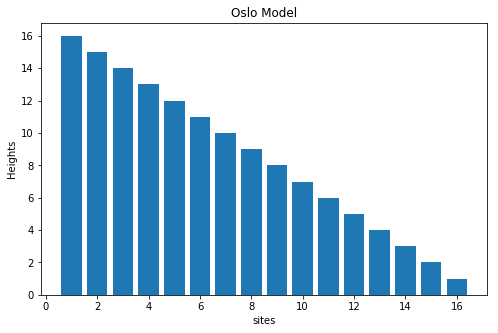

In [6]:
# Test 3, p = 1, z_th = [1], Recurrent state should be L = 16
BTW = Oslo(16,p = [1])
BTW.run(plot= True,N_recurrents = 10,title = "Oslo to BTW (d=1)")
time,height = BTW.get_heights(plot = False)
print("Expected = {}, Model = {:.2f}".format(16,height[0]))

In [7]:
# Test: N_s, N_r
# Test if p = 1/2, other Ls?
# Test for another p (p = 1/3?)
# average avalanche size / height (pg 279) --> <s> ~ L^2, but seems only apply when grains added randomly (not Oslo)
# <influx> = <outflux>? N grains, or energy, would be applicable to oslo cuz changes!! ~ but again, not Oslo?

### 1.3. Test 4: Recurrent Configurations

For the Oslo model, we expect N_R to be 5 for L = 2

In [8]:

L = 1
N_S = 3**L

def N_R(L):
    phi = (1+np.sqrt(5))/2
    N_R = 1/np.sqrt(5)* (phi *(1+phi)**L + 1/(phi * (1+phi)**L))
    return N_R

Oslo_2 = Oslo(2,p = [0.5,0.5])
a,b,c,configurations = Oslo_2.run(plot= False,N_recurrents = 1000)

print(Counter(str(e) for e in configurations))
print("\n-- Transient configurations = [0,0],[2,0] or [0,1]")

Counter({'[1, 2]': 385, '[2, 2]': 260, '[2, 1]': 201, '[0, 2]': 81, '[1, 1]': 75, '[0, 0]': 1, '[1, 0]': 1, '[2, 0]': 1})

-- Transient configurations = [0,0],[2,0] or [0,1]


## 2. Height of the Pile

This was implemented in the oslo model. Everytime a grain is added to the pile, the cound it increased by one. Everytime the final pile is reached, the count is reduced by negative one. Reduce by -1 as allows for multiple avalanches caused by one grain that could reduce the heights further.

Height of the pile $h(t;L)$is defined as 

$$h(t;L) = \sum^L_{i=1}z_i(t)$$

where $z_i(t)$ are the slopes. This essentially finds the sum of all the slopes, to find the height of the first pile.



### Task 2a 
Increasing the size of the system, would increase the number of recurrent configurations, as seen from the plot below. Recurrent configurations occur when the height of the pile begins to fluctuate around a certain value. 

When the system is in the transient state, the height continues to increase against time, where as it plateaus or fluctuates about a certain value once it has entered the recurrent state. 

In [73]:
sizes = np.array([4,8,16,32,64,128,256])
# sizes = np.array([4,8,16,32])

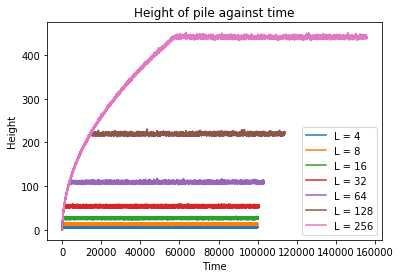

In [248]:
Oslo_models = [Oslo(L) for L in sizes]

times_sample = []
heights_sample = []

for Oslo_L in Oslo_models:
#     Oslo_L.run(N_runs = 10000)
    Oslo_L.run(N_recurrents = 100000)
    time,height = Oslo_L.get_heights()
    times_sample.append(time)
    heights_sample.append(height)
plt.legend()

### Task 2b
Cross-over time is the number of grains $\textbf{before}$ an added grain induces a grain to leave the system. It is seen as $t_c(L)$:
$$t_c(L) = \sum_{i=1}^{L} z_i  i$$

where $z_i$ are the local slopes in the system to which an added grain induces a flow out of the system for the first time.

Numerically add to t_c, until you enter the condition where it enters the last site. At this point 

[13, 13, 13, 13, 13, 13, 13, 13, 13, 13]
[68, 68, 68, 68, 68, 68, 68, 68, 68, 68]
[225, 225, 225, 225, 225, 225, 225, 225, 225, 225]
[840, 840, 840, 840, 840, 840, 840, 840, 840, 840]
[3393, 3393, 3393, 3393, 3393, 3393, 3393, 3393, 3393, 3393]
[13829, 13829, 13829, 13829, 13829, 13829, 13829, 13829, 13829, 13829]
[55848, 55848, 55848, 55848, 55848, 55848, 55848, 55848, 55848, 55848]


Text(0,0.5,'Average cross-over time $<t_C>$')

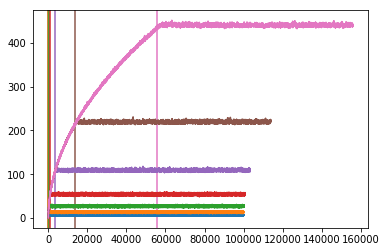

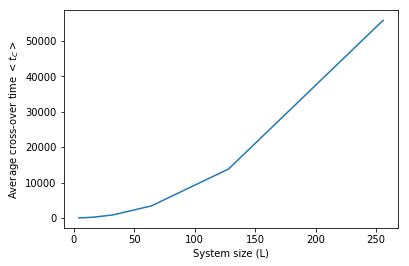

In [249]:
crossover_avgs = []
for Oslo_L in Oslo_models:
    times = []
    for N in range(10):
        times.append(Oslo_L.get_cross_over_times())
    print(times)
    avg_time = np.mean(times)
    crossover_avgs.append(avg_time)

[plt.axvline(crossover_avgs[i],color = "C{}".format(i))for i in range(len(crossover_avgs))]
[plt.plot(times_sample[i],heights_sample[i])for i in range(len(times_sample))]

plt.figure()
plt.plot(sizes,crossover_avgs)
plt.xlabel("System size (L)")
plt.ylabel("Average cross-over time $<t_C>$")

### Task 2c: Height, Cross-over Time - L Dependance

a. Considering the height of the pile $h(t;L)$ as 

$$h(t;L) = \sum^L_{i=1}z_i(t)$$

where $L$ is the length/size of the system, $z_i$ is the slope at site $i$ and $t$ is time or number of grains added to system since the start. We can approximate all the slopes at all sites $i$ in the above equation as an average value. This reduces the equation to

$$\begin{equation}\begin{aligned} h(t;L) &= \sum^L_{i=1}<z> \\&= L \cdot <z>  \\ \Rightarrow h(t;L) &\propto L\end{aligned}\end{equation}$$


thus showing that $h(t;L) \propto L$ in a linear relationship.

b. Similarly for cross-over time, we have the following relation

$$t_c(L) = \sum^L_{i=1} z_i \cdot i$$

where $t_c(L)$ is the cross-over time. We can perform the same apprroximation of averaging all the slopes, to remove the slopes from the sum. Applying the arithmetic sum formula $S_n = \frac{N(N+1)}{2}$, we obtain


$$\begin{equation}\begin{aligned} t_c(L) &= <z> \cdot \sum^L_{i=1}  i \\ &=  <z> \cdot \frac{L(L+1)}{2} \approx <z> \cdot L^2 \\ \Rightarrow t_c(L) &\propto L^2 \end{aligned}\end{equation}$$

showing cross-over time approximated as a quadratic relation.


### Task 2d: Finite Scaling Ansatz
The somewhat counterintuitive idea behind finite-size scaling is to use the dependence of measured properties on finite system size to extract critical exponents for the infinite system.

$$h(t;L)\propto L^{\tau}\mathcal{F}\Big(\frac{t}{t_C}\Big)$$

where define $x = \frac{t}{t_C}$

We can also describe cross-over time as 

$$ t_C \propto L^D $$

where $L$ is the length of the system and D is another critical exponent

From the situation in Task 2c), we expect $h \sim L$ and $t_C \sim L^2$, indicating $\tau \sim 1$ and $D \sim 2$. 

We want the finite scaling function F to be linear for small x, and be constant of large arguments? 

Smooth out the data using

$$\tilde h(t;L) = \frac{1}{M} \sum^M_{j=1} h^j(t;L) $$


In [250]:
# Oslo_models = [Oslo(L) for L in sizes]

heights = []
avgs = []
for Oslo_L in Oslo_models:
    heights_full = []
    for N in range(10):
#         Oslo_L.run(N_runs=10000)
        time,heights_L = Oslo_L.get_heights(plot = False)
        heights_full.append(np.array(heights_L))
    
#     # Adds lists of different lengths
#     height = np.array([(n) for n in zip_longest(*heights_full)])
#     height = [np.mean(list(filter(None, height[i]))) for i in range(len(height))]
    height = list(sum(heights_full)/len(heights_full))
    # First value is Nan, as mean of zero
    height.remove(height[0]) 

    heights.append(height)
    
# print(len(heigh1ts))

# print(heights)

# print(heights)

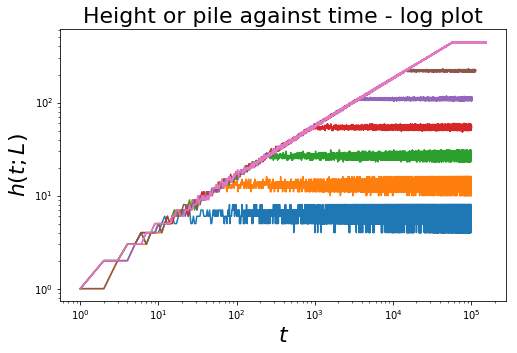

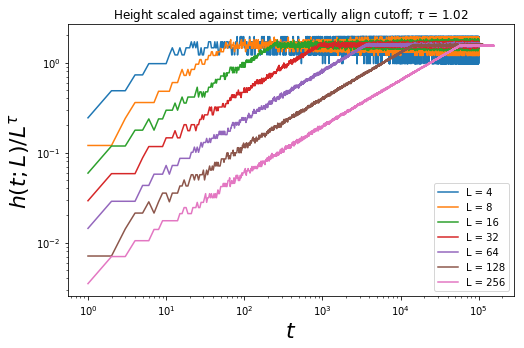

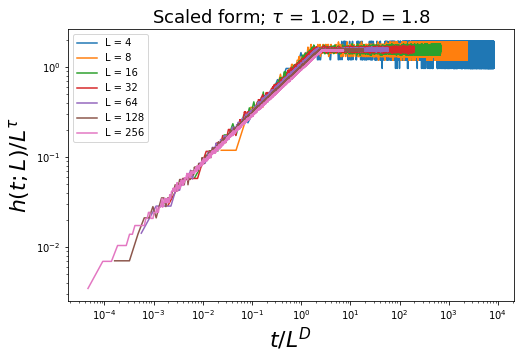

In [251]:
tau = 1.02 
D = 1.8

times = [np.arange(1,len(height)+1,1) for height in heights]

# Heights/L
heights_L = [heights[i] / sizes[i]**tau for i in range(len(sizes))]

# Times/L
times_L = [times[i]/ sizes[i]**D for i in range(len(sizes))]

#Plotting
plt.figure(figsize = (8,5))
plt.title("Height or pile against time - log plot",fontsize = 22)
plt.ylabel("$h(t;L)$",fontsize = 22)
plt.xlabel("$t$",fontsize = 22)
[plt.loglog(times[i],heights[i],label = "L = {}".format(sizes[i])) for i in range(len(heights))]
# [plt.axvline(x = x) for x in crossover_avgs]

plt.figure(figsize = (8,5))
plt.title(r"Height scaled against time; vertically align cutoff; $\tau$ = {}".format(tau))
plt.ylabel(r"$h(t;L) / L^{\tau}$",fontsize =22)
plt.xlabel("$t$",fontsize = 22)
[plt.loglog(times[i],heights_L[i],label = "L = {}".format(sizes[i])) for i in range(len(heights))]
plt.legend()

plt.figure(figsize = (8,5))
plt.title(r"Scaled form; $\tau$ = {}, D = {}".format(tau,D),fontsize = 18)
plt.ylabel(r"$h(t;L) / L^{\tau}$",fontsize =22)
plt.xlabel("$t / L^D$",fontsize = 22)
[plt.loglog(times_L[i],heights_L[i],label = "L = {}".format(sizes[i])) for i in range(len(heights))]
plt.legend()


Combining these two situations, for times less than the cross over time, we expect the height to change as $h \sim \sqrt{t}$, hence the first exponent we will try is 0.5. This is reinforced as when looking at $h$ against $t$ on a non-log plot, the transient state looks to progress as a square root function. 

The point of this is to align vertically the cut off height of the pile; aligning the 'height' where the decay occurs. 'height' as align in height * time^tau

Then can apply the scaling ansatz, to find an expression that can describe an infinite system size, through its critical components, by extrapolating from a sample of finite size systems.

From analysing the log plots of heights, we can see that the scaling ansatz should follow

$$\mathcal{F} \propto \left\{\begin{array}{ll}
{\mathcal{F}(0)+\mathcal{F}^{\prime}(0) x+\frac{1}{2} \mathcal{F}^{\prime \prime}(0) x^{2}+\cdots} & {\text { if } t\ll t_C \text{ (or }x \ll 1)} \\
{\text{constant}} & {\text { if } t \gg t_C \text{ (or } x \gg 1)} 
\end{array}\right.$$

Must be like this so that it applies the decay at the correct time

and again since, we know t ~ L^2, we expect D ~ 2. 

<Figure size 576x360 with 0 Axes>

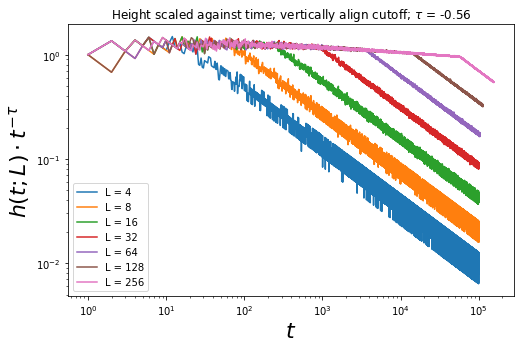

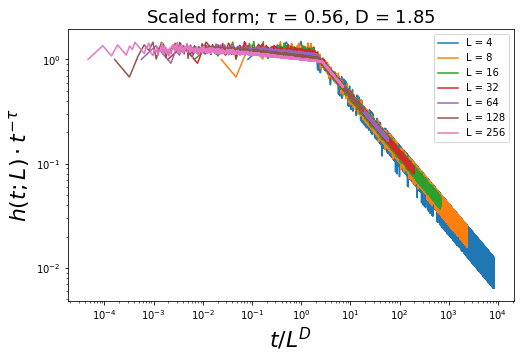

In [252]:
plt.figure(figsize = (8,5))

tau = 0.56
times_tau = [np.array(list(map(float,times[i]))) ** (-tau) for i in range(len(times))]
heights_t = [heights[i] * times_tau[i] for i in range(len(heights))]

plt.figure(figsize = (8,5))
plt.title(r"Height scaled against time; vertically align cutoff; $\tau$ = {}".format(- tau))
plt.ylabel(r"$h(t;L) \cdot t^{- \tau}$",fontsize =22)
plt.xlabel("$t$",fontsize = 22)
[plt.loglog(times[i],heights_t[i],label = "L = {}".format(sizes[i])) for i in range(len(heights))]
plt.legend()

D = 1.85
# D = 2
plt.figure(figsize = (8,5))

plt.title(r"Scaled form; $\tau$ = {}, D = {}".format(tau,D),fontsize = 18)
plt.xlabel("$t / L^D$",fontsize = 22)
plt.ylabel(r"$h(t;L) \cdot t^{- \tau}$",fontsize =22)
[plt.loglog(times_L[i],heights_t[i],label = "L = {}".format(sizes[i])) for i in range(len(heights))]
plt.legend()

### Task 2e

Estimate $a_o$ and $\omega_1$ due to the corrections to scaling

In [253]:
def avg_gradient_log(x,y):
    """
    Finds the average gradient on a log scale. 
    
    Parameters: x and y axis values (non log values)
    Returns: a gradient value from a log plot
    """
    gradients = []
    
    y = np.log10(y)
    x = np.log10(x)
    for i in range(len(x)):
        for j in range(len(x)):
            if i != j:
                m = (y[i] - y[j] )/ (x[i]  - x[j])
                gradients.append(m)
    return np.mean(gradients)

def _chi_square(x,y):
    """
    Calculates chi-square for a given set of x-y values, compared to a 
    straight line fit. 
    
    Parameters: x and y axis values
    Returns: Sum of chi-square values
    """
    m = (y[-1] - y[0]) / (x[-1] - x[0])
    c = y[0] - m*(x[0])

    expected_y = [m*x_i + c for x_i in x]

    chi = [(y[i] - expected_y[i])**2 / expected_y[i] for i in range(len(y))]
    return sum(chi)

[1.5783175  1.6223125  1.65787    1.68376688 1.70224875 1.71296586
 1.72118648]
a_o = 1.7419, w_1 = 0.5033
[6.31327, 12.9785, 26.525920000000003, 53.88054, 108.94392, 219.25963000000002, 440.62374000000005]


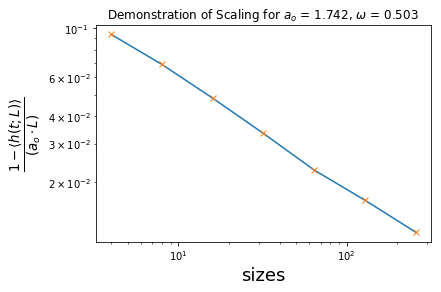

In [254]:
avg_heights = [x.get_heights_attractor(plot = False) for x in Oslo_models]
avg_heights_L = np.array([avg_heights[i]/sizes[i] for i in range(len(sizes))])
print(avg_heights_L)

# Generate a list of a_o values
del_a =0.000001
a_o = np.arange(max(avg_heights_L) + del_a,1.8,del_a)

# Generate y values for different a_o predictions
y_s = [1 - np.array(avg_heights_L)/a for a in a_o]
x = sizes

# Find Absolute Chi Square Values
chis = []
for y in y_s:
    chis.append(abs(_chi_square(np.log(x),np.log(y))))
min_a_o = a_o[np.argmin(chis)]

# Generate finalised y values for best a_o
y = 1 - np.array(avg_heights_L)/min_a_o
gradient = avg_gradient_log(x,y)

print("a_o = {:.4f}, w_1 = {:.4f}".format(min_a_o,-np.mean(gradient)))

# Plot
plt.figure()
plt.title("Demonstration of Scaling for $a_o$ = {:.3f}, $\omega$ = {:.3f}".format(min_a_o,-np.mean(gradient)))
plt.loglog(x,1 - np.array(avg_heights_L)/min_a_o)
plt.loglog(x,1 - np.array(avg_heights_L)/min_a_o,'x')
plt.ylabel(r"$\frac{1-\langle h(t;L) \rangle }{(a_o \cdot L)}$",fontsize = 19)
plt.xlabel("sizes",fontsize = 18)

print(avg_heights)

The process above essentially works to minimise the Chi-square plot below, In order to find the value of $a_o$ that is the smallest

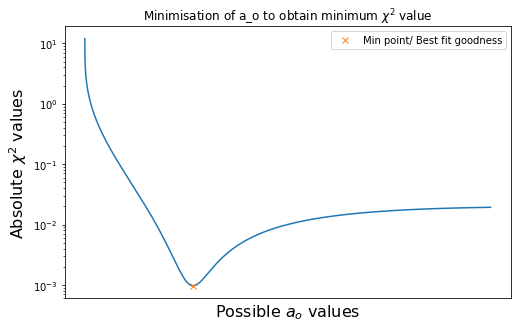

In [255]:
plt.figure(figsize=(8,5))
plt.title(r"Minimisation of a_o to obtain minimum $\chi^2$ value")

plt.loglog(a_o,chis)
plt.loglog(a_o[np.argmin(chis)],min(chis),'x',label = "Min point/ Best fit goodness")

plt.xlabel("Possible $a_o$ values",fontsize = 16)
plt.ylabel("Absolute $\chi^2$ values",fontsize = 16)
plt.legend()

### Task 2f

[0.8022168703661152, 0.9616744511527884, 1.1337495991619626, 1.3528079347785082, 1.5965760343935613, 2.04001035857609, 2.6156239049887415]
Thus power law as log plot is linear
0.27894900472922374


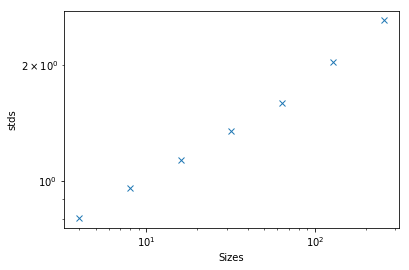

In [256]:
std_heights = [x.get_std_heights() for x in Oslo_models]

print(std_heights)

plt.loglog(sizes,std_heights,"x")
plt.xlabel("Sizes")
plt.ylabel("stds")

print("Thus power law as log plot is linear")
      
# plt.figure()
# plt.loglog(sizes,std_heights)

gradients = avg_gradient_log(sizes,std_heights)

print(gradients)

# T has to be ~ 100000 or greater for straight line 
# D is rising exponent, 2 is tc so falling exponent


Average slope = $\langle h \rangle/L \rightarrow a_o$ as $L \rightarrow \infty$, thus its standard deviation tend to zero. 

What will happen with average slope, and its standard deviation as it tends to infinity?



### Task 2g
(------TODO--------) As length increases, I'd expect the probability to be distributed as a Gaussian.

All looks a bit skewed, probably because of the later sites being not changing as often, so the larger heights ?

In [257]:
# import ast
# heights_l = [x.get_heights() for x in Oslo_models]

# [logbin(data = heights_l[i], scale = 1,zeros = False) for i in range(len(heights_l))]

values = [x.get_probability_heights() for x in Oslo_models]
# print(values)
heights = [values[i][0] for i in range(len(values))]
probs = [values[i][1] for i in range(len(values))]

# plt.figure(figsize = (13,10))
# [plt.plot(heights[i],probs[i],label = "L = {}".format(sizes[i])) for i in range(len(heights))]
# plt.legend()
# plt.xlabel("Heights")
# plt.ylabel("Probability $P(h;L)$")

# i think  you are only taking heights after crossover?

# print([list(heights[0][i] for i in range(len(heights[0])))])
# print( x = ast.literal_eval(heights[0]))
print(len(heights))

7


Since P ~ Gaussian

$$ P(h;L) = \frac{1}{\sigma_h\sqrt{2\pi}} \exp \Big[- \frac{1}{2} \Big(\frac{h - \langle h\rangle}{\sigma_h}\Big)^2\Big] $$

Key thing here is scaling the x component, that is the height component. Thus subtracting the average height$\langle h \rangle$ and dividing by the standard deviation $\sigma_h$.



In [258]:
def gauss_fit(x,y,sigma,size):
    def gaus(x,sigma):
        return 1/np.sqrt(sigma * np.sqrt(2*np.pi)) * np.exp(-x**2)
    
    popt,pcov = curve_fit(gaus,x,y,p0=[sigma])

    samp_x = np.arange(-5,5,0.1)

    plt.plot(samp_x,gaus(samp_x,*popt),label='L = {}'.format(size))

5 5
[5, 6, 7, 8, 4]
5
7


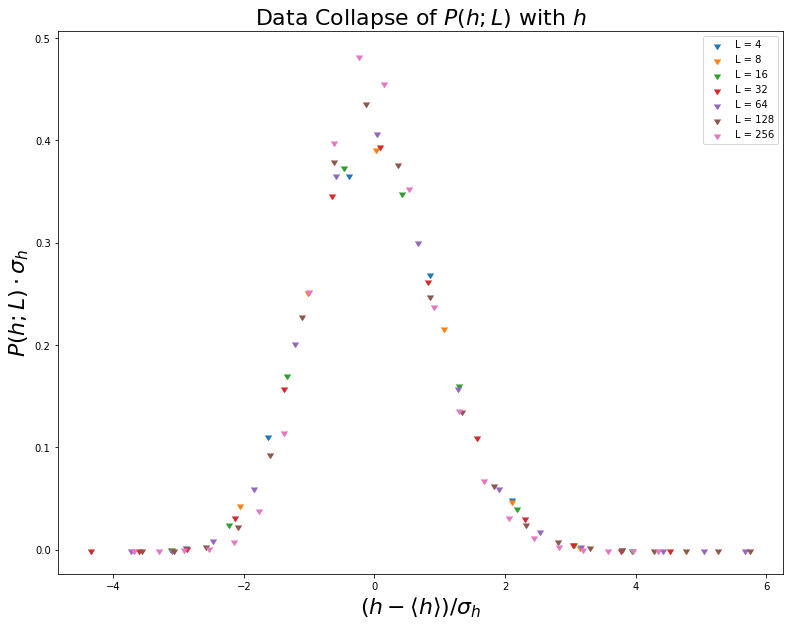

In [259]:
import matplotlib
print(len(heights[0]),len(probs[0]))
print(heights[0])
new_heights = []
new_probs = []
plt.figure(figsize=(13,10))

print(len(heights[0]))
# print(std_heights)
for i in range(len(heights)):
    x = (( heights[i] - avg_heights[i] )/ (std_heights[i]))

    y = probs[i] * std_heights[i]#/ max(probs[i])

    plt.plot(x,y,'x',label = "L = {}".format(sizes[i]),marker = matplotlib.markers.CARETDOWNBASE)
        
    new_heights.append(x)
    new_probs.append(y)
    
    # Fit Gaussians
#     gauss_fit(x,y,std_heights[i],size = sizes[i])
    
# plt.xlim(-5,5)
plt.legend()
plt.ylabel("$P(h;L) \cdot \sigma_h$",fontsize = 22)
plt.xlabel(r"$(h - \langle h\rangle)/\sigma_h$",fontsize = 22)
plt.title("Data Collapse of $P(h;L)$ with $h$",fontsize = 22)

print(len(new_heights))


#### $\sigma_h$ scaling against system size

Smaller lengths encounter boundary effects. if z_i completely independent, expect fully linear

Text(0,0.5,'$\\sigma_h$')

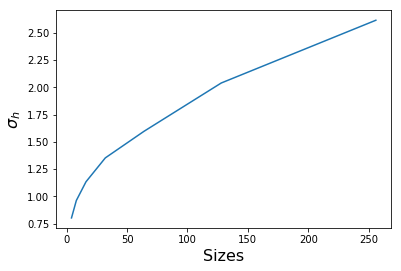

In [260]:
plt.plot(sizes,std_heights)
plt.xlabel("Sizes",fontsize = 16)
plt.ylabel("$\sigma_h$",fontsize = 16)

#### Skewness of Gaussian 
The skewness of the gaussian can be found from the Fisher-Pearson Coefficient of Skewness. It has the following form of

$$g_{1}=\frac{m_{3}}{m_{2}^{3 / 2}}$$

where,
$$m_{i}=\frac{1}{N} \sum_{n=1}^{N}(x[n]-\bar{x})^{i}$$

where $g_1$ is the skewness, $i$ is the ith moment and \bar{x} is the mean. 

This can also be adjusted for bias, which is done for the case of the data collapse as it does not encompass the full sample set, requiring correction to statistical bias. Thus the skewness is instead given by:

$$G_{1}=\frac{\sqrt{N(N-1)}}{N-2} \frac{m_{3}}{m_{2}^{3 / 2}}$$

where $G_1$ is the skewness.

We expect a skewness of zero for a normal distribution, but it is non-zero for the randomly generated case as it is random. 

(Source:https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html)

In [261]:
from scipy.stats import skew 
flatten = lambda l: [item for sublist in l for item in sublist]

x = flatten(new_heights)
print(x)

print("Skewness for randomly generated Gaussian = ",
      skew(np.random.normal(0,0.1,10000000)),"(Expect 0)")
print("Skewness for randomly collapsed Gaussian = ",skew(x,bias = False))



[-1.6370510874455317, -0.3905053752572296, 0.8560403369310726, 2.102586049119375, -2.883596799633834, -1.0174960963422108, 0.02235683809029857, 1.0622097725228081, -2.0573490307747204, 2.1020627069553175, 3.141915641387827, -3.09720196520723, -1.3459056577642208, -0.4638766799906689, 0.41815229778288293, 1.3001812755564348, 2.1822102533299867, 3.0642392311035382, -2.2279346355377725, 3.94626820887709, -3.1099636133113244, -3.6077109503346323, -2.868507716607498, -2.129304482880363, -1.3901012491532283, -0.6508980154260937, 0.08830521830104097, 0.8275084520281757, 1.5667116857553103, 2.305914919482445, 3.0451181532095797, 3.7843213869367145, 4.523524620663849, -4.3469141840617675, -3.096576607375852, -2.470236252480172, -1.8438958975844928, -1.2175555426888132, -3.7229169622715315, -0.5912151877931334, 0.03512516710254618, 0.6614655219982258, 1.2878058768939054, 1.914146231789585, 2.540486586685265, 3.1668269415809442, 3.793167296476624, 4.419507651372304, 5.045848006267983, 5.672188361

(----------TODO-----------)

Doesn't produced what we theoretically expect. z_i is not independent, as depends on the slope of driven. if you add all randomly, at random sites, should get gaussian to collapse, but because you dont, means that slopes aren't independent. Sites are driven at i=1. z_i not independent, depends on previous slopes? need to think about it. 

What theoretical prediction does the assumption that zi are independent, identically distributed
random variables with finite variance yield for the scaling of σh(L)? 

This would imply that sigma_h scales with probabilty? well it should definitely be higher, becasue for L>>1, it is too small. because all the slopes heights are around a certain value? or all the slopes are around a certain value, so the bigger slopes kew the values?

Comment on your
finding and the implications hereof.


## Task 3a: Log-Binning
Data processing
1. Calculate avalance sizes by counting everytime a relaxation occurs
    * i.e. every instance where z[i] > z_th[i]
2. Run throught logbinning
    * Which returns probability of avalanche logbinned
    * scale set to 1.1, conservative estimate that reduces noise
    * zeros false as to avoid errors in log plotting
    * N set to 10^9 values, for log plotting. 
3. Plot on log plot of Probabilities against avalanche size s

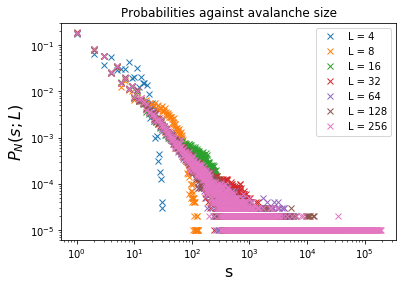

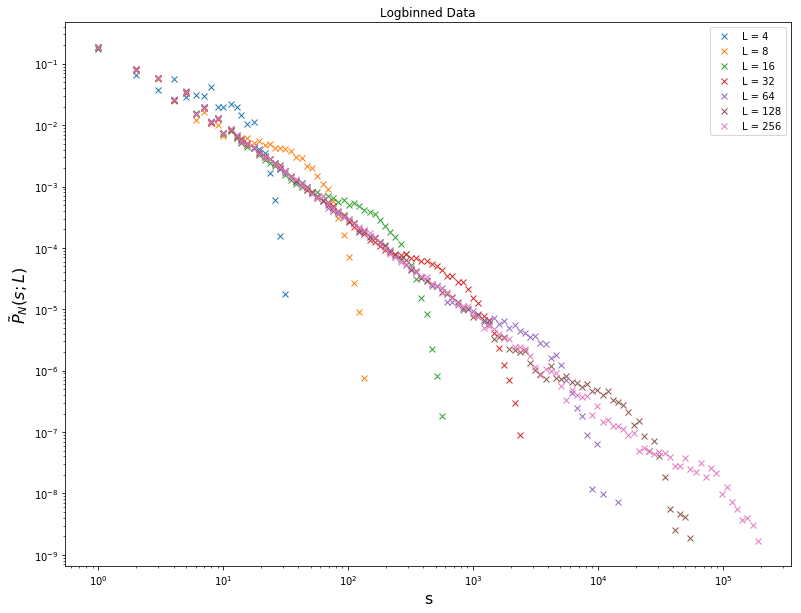

In [262]:
from logbin230119 import logbin

avalanches = [x.get_avalanches_crossed() for x in Oslo_models]
# probs = x.get_avalanche() for x in Oslo_models

# Setting scale to 1. returns the unbinned data, as del_s_j factor reduces to 1
plt.figure()
probs_unbinned = [(logbin(data = avalanches[i], scale = 1,zeros = False)) for i in range(len(avalanches))]
[plt.loglog(*probs_unbinned[i],'x',label = "L = {}".format(sizes[i])) for i in range(len(avalanches))]
plt.title("Probabilities against avalanche size")
plt.xlabel ("s",fontsize = 16)
plt.ylabel(r"$P_N(s;L)$",fontsize = 16)
plt.legend()

plt.figure(figsize = (13,10))
probs_binned = [(logbin(data = avalanches[i], scale = 1.1,zeros = False)) for i in range(len(avalanches))]
# print(probs_binned)
[plt.loglog(*probs_binned[i],'x',label = "L = {}".format(sizes[i])) for i in range(len(avalanches))]
plt.title("Logbinned Data")
plt.xlabel ("s",fontsize = 16)
plt.ylabel(r"$\tildeP_N(s;L)$",fontsize = 16)
plt.legend()


Smaller system sizes have boundary effects, causing zigzag 

odd avalanches more likley, even avalanches less less likely

* For unbinned data, can see that cutoff only begins to show for large N, i.e. by increasing the statistics
* Log binning reduces noises for large s
* Approximates probability well
* But lose information on the avalanche, just know it is somwhere in the interval, not exactly where
* And there is no exact correspondance between P and P^~, just approximates to rid the noise.

### Task 3b: Scaling Ansatz Collapse
Yes it is consistent

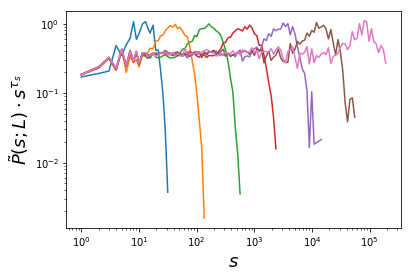

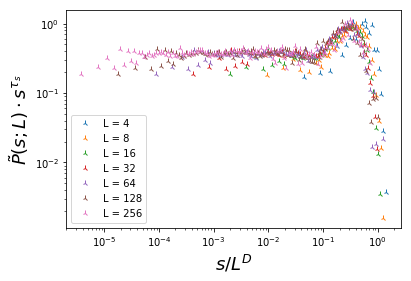

In [273]:
D = 2.25
tau_s = 1.5555555

y = [probs_binned[i][1] * probs_binned[i][0]**(tau_s) for i in range(len(probs_binned))]
x = [probs_binned[i][0] for i in range(len(probs_binned))]
[plt.loglog(x[i],y[i]) for i in range(len(x))]
plt.xlabel("$s$",fontsize = 18)
plt.ylabel(r"$\tildeP(s;L) \cdot s^{\tau_s}$",fontsize = 18)

x = [probs_binned[i][0] / sizes[i]**D for i in range(len(probs_binned))]
plt.figure()
[plt.loglog(x[i],y[i],"2",label = "L = {}".format(sizes[i])) for i in range(len(x))]
plt.xlabel("$s/ L^D$",fontsize = 18)
plt.ylabel(r"$\tildeP(s;L) \cdot s^{\tau_s}$",fontsize = 18)
plt.legend()

### Task 3c: Moments
$$\left\langle s^{k}\right\rangle \propto L^{D\left(1+k-\tau_{s}\right)} \quad \text { for } L \gg 1,1+k-\tau_{s}>0$$

Tau_s = 1.5563, D = 2.2243
[array([0.00670507, 0.00666614, 0.00666497, 0.00605789, 0.00518608,
       0.00305883, 0.        ]), array([ 0.9605177 ,  0.41522571,  0.14581015,  0.0219343 , -0.0510165 ,
       -0.0673145 ,  0.        ]), array([ 2.04338975,  0.73069696,  0.20660838,  0.01049419, -0.09652759,
       -0.09256806,  0.        ]), array([ 3.59239824,  1.11542059,  0.28735013,  0.02702431, -0.07562512,
       -0.03767179,  0.        ])]


c:\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
c:\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in log10
c:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
c:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
c:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


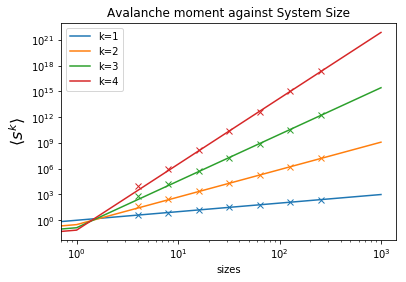

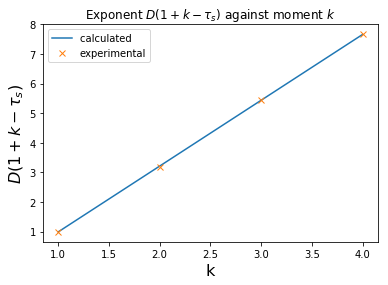

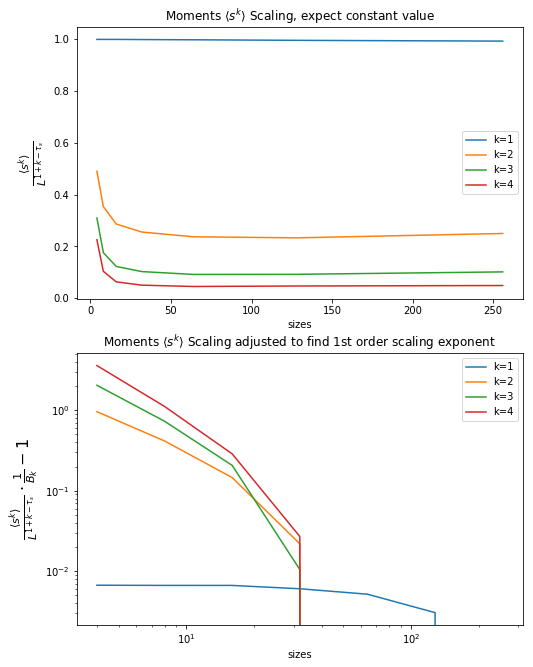

In [264]:
from scipy import stats

k_mom = [1,2,3,4]
moments = [x.get_k_moment() for x in Oslo_models]

# Obtain value for k_th moment from each Oslo model size
k_1 = [moments[i][0] for i in range(len(moments))]
k_2 = [moments[i][1] for i in range(len(moments))]
k_3 = [moments[i][2] for i in range(len(moments))]
k_4 = [moments[i][3] for i in range(len(moments))]

# Function for exponent
def X(k,D = 2.25,tau_s=1.55555):
    return D*(1+k-tau_s)

# Form moments into a list
k_s = [k_1,k_2,k_3,k_4]

# Prepare lists
gradients = []
ints = []

# Index to pick points to fit, ignore L = 4,8
sub = 2

# Fit line f best fits
for i in range(len(k_s)):
    m,c,a,a,a = stats.linregress(np.log10(sizes)[sub:],np.log10(k_s[i])[sub:])
    gradients.append(m)
    ints.append(c)
slope,intercept,a,b,c = stats.linregress([1,2,3,4],gradients)

# Calculate D and tau values. 
D = slope
tau_s = 1 - intercept/D
print("Tau_s = {:.4f}, D = {:.4f}".format(tau_s,D))

# Demonstrate corrections to scaling,
# Average S^k value / L^X
s_scaled = [np.array(k_s[i])/(np.array(sizes)**X(np.array(k_mom[i]),D,tau_s))for i in range(len(k_mom))]

# Average S^k value / L^X using ideal D and tau values
s_ideal = [np.array(k_s[i])/(np.array(sizes)**X(np.array(k_mom[i])))for i in range(len(k_mom))]

# Average S^k value / L^X adjusted to find scaling exponent
B_k = (np.array([s[-1] for s in s_ideal]))
s_adjusted = [s_ideal[i] / B_k[i] - 1 for i in range(len(B_k))]

m,c,a,a,a = stats.linregress(np.log10(sizes)[sub:],np.log10(s_adjusted[i])[sub:])

print(s_adjusted)

# Plot
samp_x = (np.arange(0,1000,1))

plt.figure()
[plt.loglog(sizes,k_s[i],'x')for i in range(len(k_s))]
[plt.loglog(samp_x,samp_x**gradients[i]*10**ints[i],color = "C{}".format(i),
           label = "k={}".format([1,2,3,4][i])) for i in range(len(ints))]
plt.xlabel("sizes")
plt.ylabel(r"$\langle s^k\rangle $",fontsize = 16)
plt.title("Avalanche moment against System Size")
plt.legend()

plt.figure()
plt.title(r"Exponent $D(1+k-\tau_s)$ against moment $k$")
plt.plot([1,2,3,4],X(np.array([1,2,3,4]),D,tau_s),label = "calculated ")
plt.plot([1,2,3,4],gradients,'x',label = "experimental")
plt.legend()
plt.xlabel("k",fontsize = 16)
plt.ylabel(r"$D(1+k-\tau_s)$",fontsize = 16)

fig,(ax1,ax2)= plt.subplots(2,1,figsize = (8,11))
[ax1.plot(sizes,s_ideal[i],label = "k={}".format(k_mom[i]))for i in range(len(s_ideal))]
[ax2.loglog(sizes,s_adjusted[i],label = "k={}".format(k_mom[i]))for i in range(len(s_adjusted))]

ax1.set_title(r"Moments $\langle s^k \rangle$ Scaling, expect constant value")
ax1.set_ylabel(r"$\frac{\langle s^k \rangle}{L^{1+k-\tau_s}}$",fontsize =16)
ax1.set_xlabel("sizes",fontsize =10)
ax1.legend()

ax2.set_title(r"Moments $\langle s^k \rangle$ Scaling adjusted to find 1st order scaling exponent")
ax2.set_ylabel(r"$\frac{\langle s^k \rangle}{L^{1+k-\tau_s}} \cdot \frac{1}{B_k} -1$",fontsize =16)
ax2.set_xlabel("sizes",fontsize =10)
ax2.legend()


## Additional Notes

#### Machine Epsilon
Jupyter Notebook works in 32-bit, need to change certain calculations to 64-bit as machine epsilon is too small causing overflow errors

In [ ]:
print("32-bit Machine Epsilon:",np.finfo(float).eps)

#### Random Funciton Efficiency Test

In [ ]:
import timeit

mysetup = """
import numpy as np
import random
L =100
prob = [0.5,0.5]
z_ths = [1,2]
"""
mycode = "np.random.choice(z_ths,p=prob)"
print("Numpy Random: ",timeit.timeit(setup = mysetup,stmt = mycode,number = 1000),"s")

mycode = "random.choice(z_ths)"
print("Inbuilt Random: ",timeit.timeit(setup = mysetup,stmt = mycode,number = 1000),"s")

# Improvements

1)  Do more tests

~~2a) Reflect upon results obtained in terms of transient and recurrent~~

2d) How does scaling function F scale for large or small x? How does h vary as a function of t during transient (describe plot)

    * Linear increase and constant. constant value as small fluctuations about a constant value. zig zags? L smaller more fluctutations?

~~2e) Formalize procedure of ao~~

~~2f) What will happen for average slope and standard deviation as L --> infinity~~

2g) Expect ideal Gaussian, but it is slightly skewed. 
	Talk about unindependent sigma_h What does independent z_i yield for scaling of sigma_h?
		Comment - talk about unindependent values?
    ~~Measure Skewness? (https://en.wikipedia.org/wiki/Skewness)~~

3a) Describe qualitatively your results

3c) Explain procedure, present relevant plots, and comment on findings.
	Demonstrate corrections to scaling
    
    *If there is no correction to scaling, expect the values to be completely straight lines for small k and large k, but it isnt the case. 